In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from glob import glob
from pysolar.solar import get_altitude, radiation

from clearml import Task
from clearml import Dataset

from sklearn import linear_model
from sklearn import preprocessing

from amplify.DataGeneration import DataGenerator

In [2]:
# Constants 
BUILDING_LAT = 39.9649 
BUILDING_LON = -75.1396 

In [3]:
# ClearML Stuff
task = Task.init(project_name="amplify", task_name="power-ss-notebook")

ClearML Task: created new task id=5144f60a53014301bc8c44e45ecf4a19
ClearML results page: https://app.clear.ml/projects/f0e0b096252d4c18b9005e580afc5bce/experiments/5144f60a53014301bc8c44e45ecf4a19/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [4]:
# DataGenerator - ClearML
data_generator = DataGenerator()
# LoadData - ClearML
load_success, building_data, weather_data = data_generator.LoadData()

# # DataGenerator - Local
# data_generator = DataGenerator(use_local_data=True)
# # LoadData - Local
# load_success, building_data, weather_data = data_generator.LoadData(
#     building_data_path="../data/2021-10-19_2022-01-09_CF2.csv",
#     weather_data_path="../data/CF2_Weather_2020-2022.csv",
# )

Info: Successfully loaded building data!


/opt/tljh/user/lib/python3.9/site-packages/pysolar/radiation.py:50: RuntimeWarning:

overflow encountered in exp

/opt/tljh/user/lib/python3.9/site-packages/pysolar/radiation.py:50: RuntimeWarning:

invalid value encountered in multiply

/opt/tljh/user/lib/python3.9/site-packages/pysolar/radiation.py:50: RuntimeWarning:

overflow encountered in exp

/opt/tljh/user/lib/python3.9/site-packages/pysolar/radiation.py:50: RuntimeWarning:

invalid value encountered in multiply



Info: Successfully loaded weather data!


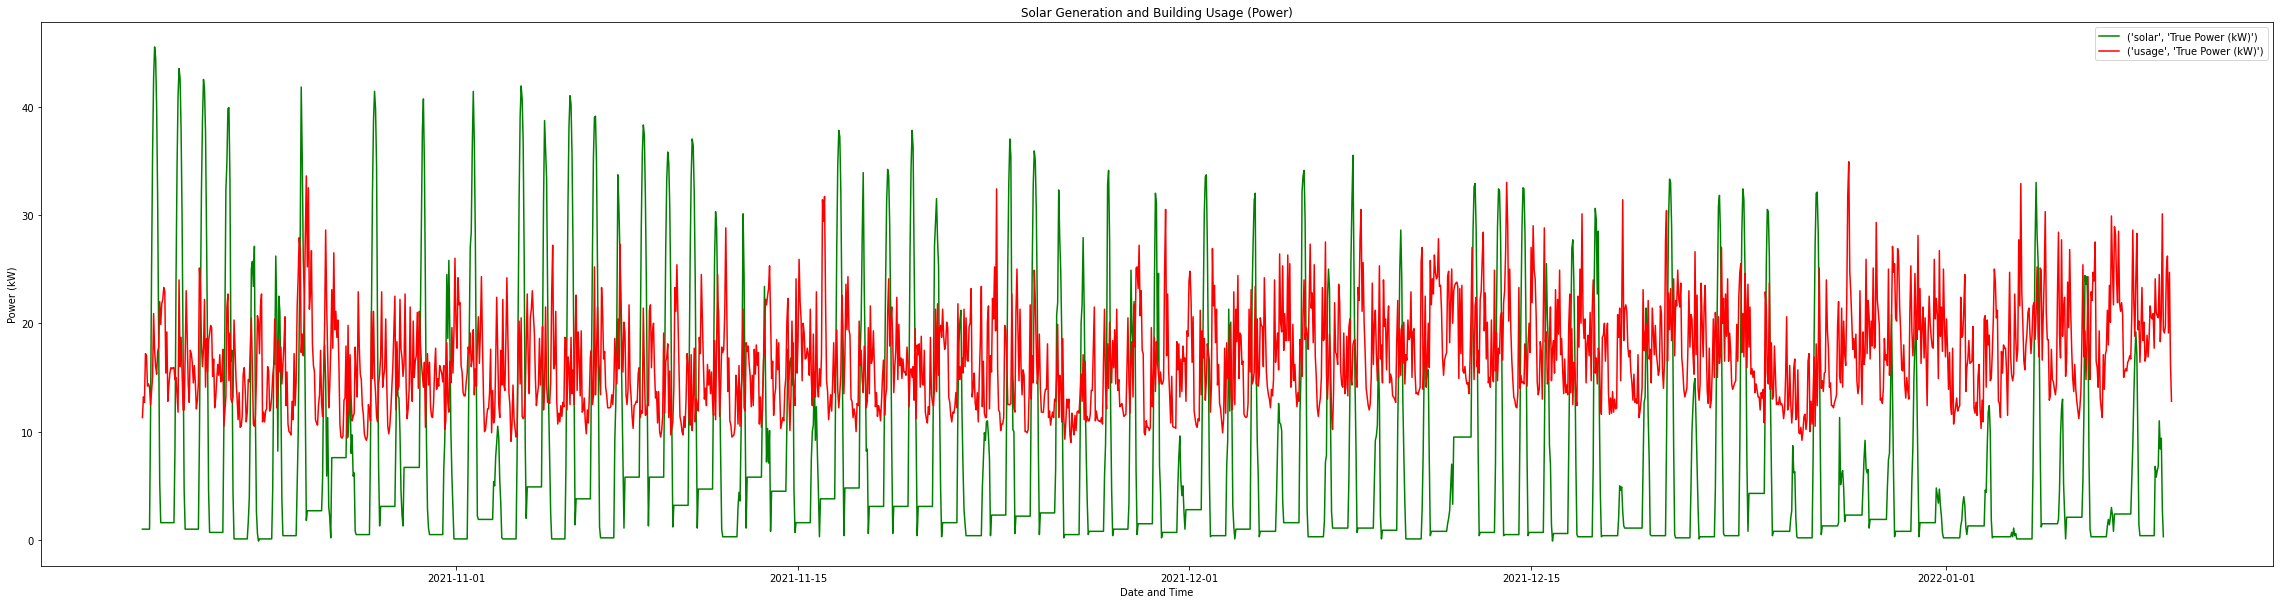

In [5]:
# Plot Power - Solar Gen vs Building Usage
fig, ax = plt.subplots(figsize=(40, 10))
plt.title('Solar Generation and Building Usage (Power)')

ax.plot(building_data.solar['True Power (kW)'], color='g')
ax.plot(building_data.usage['True Power (kW)'], color='r')

ax.set_xlabel('Date and Time')
ax.set_ylabel('Power (kW)')
plt.legend(building_data.columns)
plt.show()

In [54]:
# Build class for EWM Linear Regression to compare scaled/non-scaled features
class Weather_EWM():
    def __init__(self, features, y, split_date, scaled=True):
        self.data = features
        self.y = y
        self.split_date = split_date
        self.scale = scaled
    
    # Reversed-Recombined EWMA for improved accuracy
    def ewm_calculator(self):
        
        # Create dataframe To collect data
        self.ewm_out = pd.DataFrame()  
        
        # Calculate fwd and bwd EWMA
        self.ewm_out['fwd'] = self.y.ewm(span=24).mean()
        self.ewm_out['bwd'] = self.y[::-1].ewm(span=24).mean()

        # Reversed-Recombined EWMA
        self.ewm_out['combo'] = self.ewm_out.mean(axis=1)                                                    

        return self.ewm_out
           
        

    # Test/Train split and standardization of weather data
    def weather_prep(self):
        
        # Run ewma calculator
        self.ewm = self.ewm_calculator()

        # Test / Train split for Y based on chosen split_date
        self.ewm_train = self.ewm[self.ewm.index <= self.split_date]        
        self.ewm_test = self.ewm[self.ewm.index > self.split_date]
        
        # Test/Train split for Weather data to match Y-data
        self.weather_train = self.data[:len(self.ewm_train)]
        self.weather_test = self.data[len(self.ewm_train):]
        
        # Scale features in training set:
        if self.scale:
            self.weather_scaler = preprocessing.StandardScaler()
            self.weather_train = self.weather_scaler.fit_transform(self.weather_train)
        
        return self.weather_train, self.weather_test, self.ewm_train, self.ewm_test
        
    def weather_ewma(self):
        # Run train/test split based on date and scaling
        self.x_train, self.x_test, self.y_train, self.y_test = self.weather_prep()

        # On to the regression:
        self.lin_reg = linear_model.LinearRegression()
        self.lin_reg.fit(self.x_train, self.y_train.combo)

        self.ewm_solar_pred = self.lin_reg.predict(self.x_test)
        
        return(self.ewm_solar_pred)

/opt/tljh/user/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning:

X has feature names, but LinearRegression was fitted without feature names



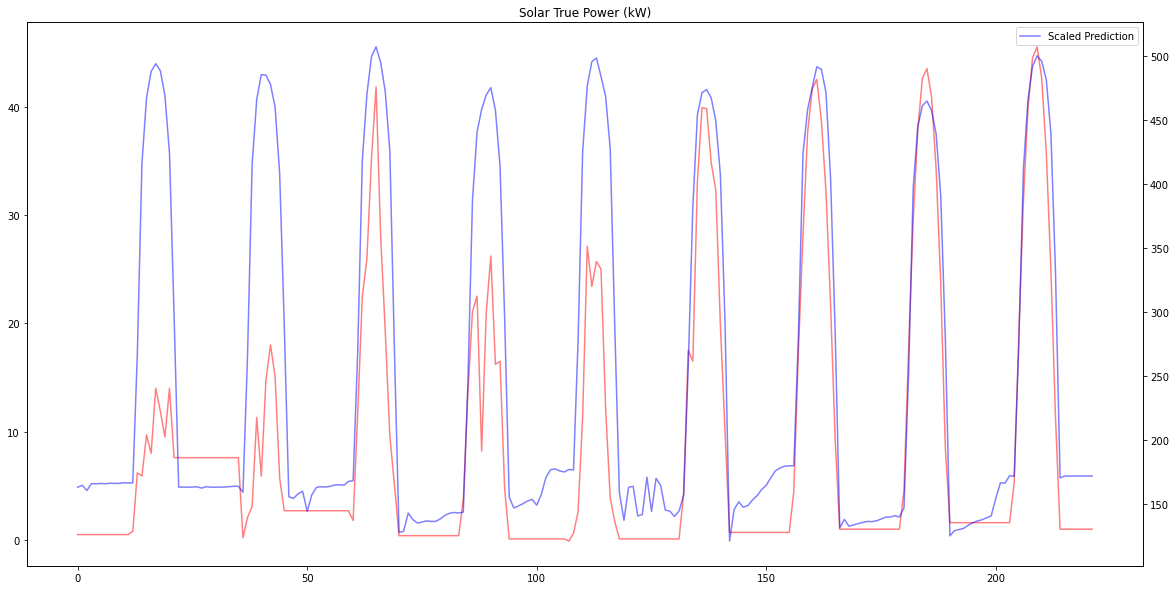

/opt/tljh/user/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning:

X has feature names, but LinearRegression was fitted without feature names



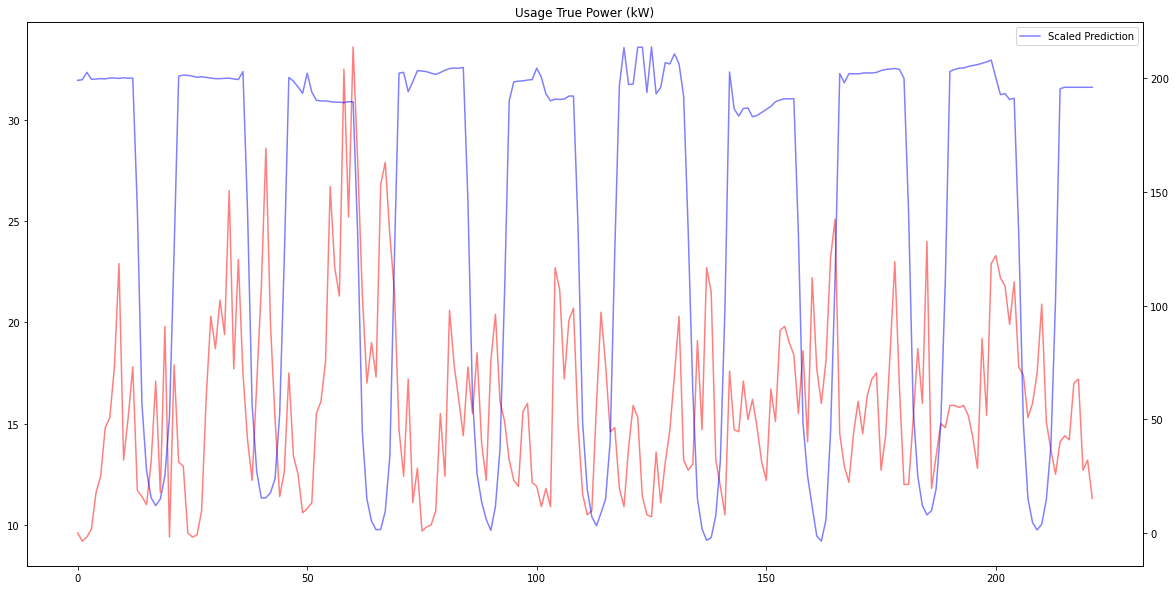

In [61]:
# Set split date for Linear Regression validation
split_date = pd.to_datetime('2022-01-01', utc=True)

# Set list of y-values we want to predict
y_vals = {'Solar' : building_data.solar['True Power (kW)'],
          'Usage' : building_data.usage['True Power (kW)']
         }

# To run the usage and power regressions
for key in y_vals:
    # Create the separate instances for scaled/not scaled:
    WE_not_scaled = Weather_EWM(features=weather_data, 
                                y=y_vals[key],
                                split_date=split_date, 
                                scaled=False
                               )
    WE_scaled = Weather_EWM(features=weather_data,
                            y=y_vals[key],
                            split_date=split_date
                           )

    # Run the linear regressions:
    lin_reg_scaled = WE_scaled.weather_ewma()
    lin_reg_not_scaled = WE_not_scaled.weather_ewma()
    
    fig, ax1 = plt.subplots(figsize=(20, 10))
    ax2 = ax1.twinx()
    
    title = key + ' ' + y_vals[key].name
    plt.title(label=title)

    # Plot prediction based on unscaled data
    # ax1.plot(lin_reg_not_scaled,
    #          color='g',
    #          alpha=0.5, 
    #          label='Predicted'
    #         )
    
    # Plot prediction based on scaled data
    ax2.plot(lin_reg_scaled,
             color='b', 
             alpha=0.5, 
             label='Scaled Prediction'
            )
    # Plot actual data 
    ax1.plot(np.array(y_vals[key][-len(lin_reg_not_scaled):]),
             color='r', 
             alpha=0.5, 
             label='Actual',
            )
    
    plt.xlabel('Hrs in future')
    plt.legend()
    plt.show()